<a href="https://colab.research.google.com/github/NadhemBenhadjali/Detection-of-Personal-Protective-Equipment-on-Construction-Sites-for-Workplace-Safety/blob/main/GODS_FINAL_ONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Detection of Personal Protective Equipment on Construction Sites for Workplace Safety***

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Collection


In [ ]:
# Load the CSV file

data_df = pd.read_csv('/content/drive/MyDrive/zindi/dataaugmented_dataframe3.csv') #(this is the data after augmentation)
test_df = pd.read_csv('/content/drive/MyDrive/zindi/Test.csv')
Train_df=pd.read_csv('/content/drive/MyDrive/zindi/Train.csv')
print(data_df.shape)

(4835, 11)


In [ ]:
Train_df

,filename,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle
0,youtube-348_jpg.rf.c478843562d5236a46c6448ecc3...,1,1,0,1,1,1,0,1,1,1
1,youtube-196_jpg.rf.c4db8b391b275b84d6183839008...,1,0,1,1,1,1,1,1,1,0
2,construction-1-_mp4-46_jpg.rf.c4db8e0500825ba1...,1,1,1,0,1,1,0,0,1,0
3,youtube-710_jpg.rf.c4e2b15fb3e7fac762b9a0f5457...,1,1,0,1,1,1,0,1,1,0
4,construction-2-_mp4-15_jpg.rf.c4fcd7ed43e0f6c2...,0,1,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2598,youtube-376_jpg.rf.80a8991715a86c564839a8431e3...,1,0,0,1,1,1,0,0,1,1
2599,image_620_jpg.rf.802077d46dec03a8fb49df8abfa00...,0,1,1,1,1,1,0,0,1,1
2600,construction-1029-_jpg.rf.810bacaaa71950be7f36...,0,0,1,1,0,1,0,0,1,0
2601,image_426_jpg.rf.80d515a51be484b98e9effccb8921...,0,0,1,1,1,1,1,1,1,0


In [ ]:
# Define the columns that are used for the multi-labels
label_columns = data_df.columns[1:]  # Adjust column indices if necessary

# Convert the labels into an array
train_labels = data_df.iloc[:, 1:].values
test_labels = test_df.iloc[:, 1:].values
n=train_labels.shape[1]
data_df.columns


Index(['filename', ' Hardhat', ' Mask', ' NO-Hardhat', ' NO-Mask',
       ' NO-Safety Vest', ' Person', ' Safety Cone', ' Safety Vest',
       ' machinery', ' vehicle'],
      dtype='object')

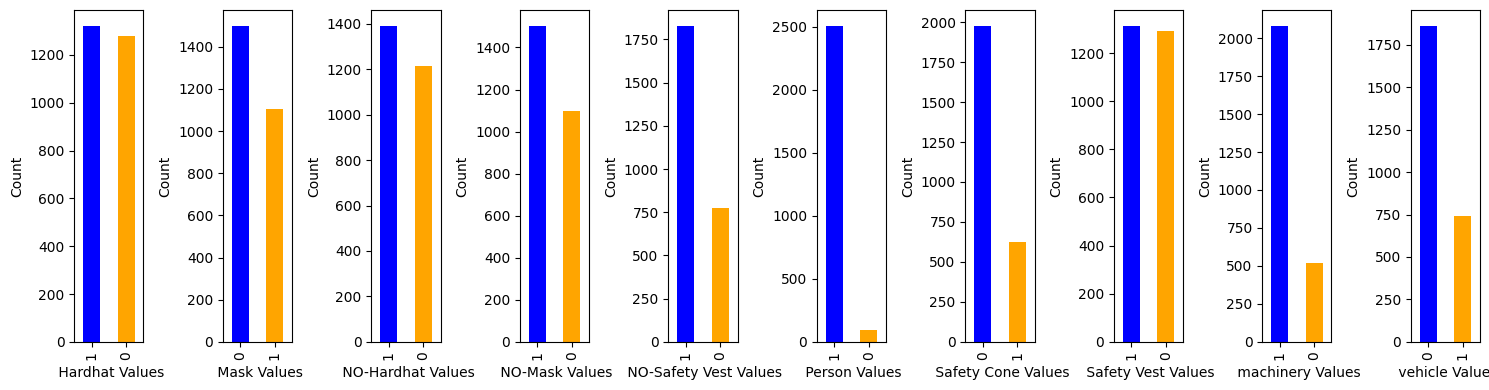

In [ ]:
classes=[' Hardhat', ' Mask', ' NO-Hardhat', ' NO-Mask',
       ' NO-Safety Vest', ' Person', ' Safety Cone', ' Safety Vest',
       ' machinery', ' vehicle']
import matplotlib.pyplot as plt

# Assuming 'classes' is a list of column names in your DataFrame 'train_df'
fig, axs = plt.subplots(1, len(classes), figsize=(15, 4))

for i, class_name in enumerate(classes):
    Train_df[class_name].value_counts().plot(kind='bar', color=['blue', 'orange'], ax=axs[i])
    axs[i].set_xlabel(f'{class_name} Values')
    axs[i].set_ylabel('Count')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# **Data preparation**

# Data Augmentation

Person:

In [ ]:
# import pandas as pd
# import numpy as np
# import imgaug.augmenters as iaa
# from PIL import Image
# import os

# # Assuming you have a DataFrame with image filenames and labels
# image_dir = '/content/drive/MyDrive/zindi/data/train'  # Directory containing images

# # Define augmentation pipeline
# seq = iaa.Sequential([
#     iaa.Fliplr(0.5),  # horizontal flips
#     iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.2))), # blur images with a sigma between 0 and 0.2
#     iaa.LinearContrast((0.9, 1.1)), # strengthen or weaken the contrast
#     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.02*255), per_channel=0.5), # add gaussian noise
#     iaa.Multiply((0.9, 1.1), per_channel=0.2), # multiply channels with random values
#     iaa.Affine(
#         scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, # scale images
#         translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)}, # translate images
#         rotate=(-5, 5), # rotate images
#         shear=(-2, 2), # shear images
#         mode='reflect' # mode used for warping
#     )
# ], random_order=True)  # apply augmenters in random order

# # Function to apply augmentation to an image
# def augment_image(image):
#     img_arr = np.array(image)
#     augmented_img = seq(image=img_arr)
#     return Image.fromarray(augmented_img)

# # Augment and save images directly into the DataFrame
# augmented_data = []
# for index, row in data_df.iterrows():
#     if row[' Person'] == 0 :
#         image_filename = os.path.join(image_dir, row['filename'])  # Construct full image path
#         image = Image.open(image_filename)
#         for _ in range(7):
#             augmented_image = augment_image(image)
#             # Save augmented image filename and other relevant data into a list
#             augmented_filename = f'augmented22_{index}_{_}.jpg'
#             augmented_image.save(os.path.join(image_dir, augmented_filename))  # Save augmented image
#             augmented_data.append({'filename': augmented_filename, ' Hardhat': row[' Hardhat'],
#                                    ' Mask': row[' Mask'], ' NO-Hardhat': row[' NO-Hardhat'],
#                                    ' NO-Mask': row[' NO-Mask'], ' NO-Safety Vest': row[' NO-Safety Vest'],
#                                    ' Person': row[' Person'], ' Safety Cone': row[' Safety Cone'],
#                                    ' Safety Vest': row[' Safety Vest'], ' machinery': row[' machinery'],
#                                    ' vehicle': row[' vehicle']})

# # Add augmented data to the original DataFrame
# augmented_df = pd.DataFrame(augmented_data)
# data_dfupdated = pd.concat([data_df, augmented_df], ignore_index=True)

# # Save augmented DataFrame
# data_dfupdated.to_csv("/content/drive/MyDrive/zindi/dataaugmented_dataframe.csv", index=False)


In [ ]:
# classes=[' Hardhat', ' Mask', ' NO-Hardhat', ' NO-Mask',
#        ' NO-Safety Vest', ' Person', ' Safety Cone', ' Safety Vest',
#        ' machinery', ' vehicle']
# import matplotlib.pyplot as plt

# # Assuming 'classes' is a list of column names in your DataFrame 'train_df'
# fig, axs = plt.subplots(1, len(classes), figsize=(15, 4))

# for i, class_name in enumerate(classes):
#     data_dfupdated[class_name].value_counts().plot(kind='bar', color=['blue', 'orange'], ax=axs[i])
#     axs[i].set_xlabel(f'{class_name} Values')
#     axs[i].set_ylabel('Count')

# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()


Machinery


In [ ]:
# import pandas as pd
# import numpy as np
# import imgaug.augmenters as iaa
# from PIL import Image
# import os

# # Assuming you have a DataFrame with image filenames and labels
# image_dir = '/content/drive/MyDrive/zindi/data/train'  # Directory containing images

# # Define augmentation pipeline
# seq = iaa.Sequential([
#     iaa.Fliplr(0.5),  # horizontal flips
#     iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.2))), # blur images with a sigma between 0 and 0.2
#     iaa.LinearContrast((0.9, 1.1)), # strengthen or weaken the contrast
#     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.02*255), per_channel=0.5), # add gaussian noise
#     iaa.Multiply((0.9, 1.1), per_channel=0.2), # multiply channels with random values
#     iaa.Affine(
#         scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, # scale images
#         translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)}, # translate images
#         rotate=(-5, 5), # rotate images
#         shear=(-2, 2), # shear images
#         mode='reflect' # mode used for warping
#     )
# ], random_order=True)  # apply augmenters in random order

# # Function to apply augmentation to an image
# def augment_image(image):
#     img_arr = np.array(image)
#     augmented_img = seq(image=img_arr)
#     return Image.fromarray(augmented_img)

# # Augment and save images directly into the DataFrame
# augmented_data = []
# for index, row in data_dfupdated.iterrows():
#     if row[' machinery'] == 0 :
#         image_filename = os.path.join(image_dir, row['filename'])  # Construct full image path
#         image = Image.open(image_filename)
#         for _ in range(1):
#             augmented_image = augment_image(image)
#             # Save augmented image filename and other relevant data into a list
#             augmented_filename = f'augmented22_{index}_{_}.jpg'
#             augmented_image.save(os.path.join(image_dir, augmented_filename))  # Save augmented image
#             augmented_data.append({'filename': augmented_filename, ' Hardhat': row[' Hardhat'],
#                                    ' Mask': row[' Mask'], ' NO-Hardhat': row[' NO-Hardhat'],
#                                    ' NO-Mask': row[' NO-Mask'], ' NO-Safety Vest': row[' NO-Safety Vest'],
#                                    ' Person': row[' Person'], ' Safety Cone': row[' Safety Cone'],
#                                    ' Safety Vest': row[' Safety Vest'], ' machinery': row[' machinery'],
#                                    ' vehicle': row[' vehicle']})

# # Add augmented data to the original DataFrame
# augmented_df = pd.DataFrame(augmented_data)
# data_dfupdated2 = pd.concat([data_dfupdated, augmented_df], ignore_index=True)

# # Save augmented DataFrame
# data_dfupdated2.to_csv("/content/drive/MyDrive/zindi/dataaugmented_dataframe2.csv", index=False)


In [ ]:
# classes=[' Hardhat', ' Mask', ' NO-Hardhat', ' NO-Mask',
#        ' NO-Safety Vest', ' Person', ' Safety Cone', ' Safety Vest',
#        ' machinery', ' vehicle']
# import matplotlib.pyplot as plt

# # Assuming 'classes' is a list of column names in your DataFrame 'train_df'
# fig, axs = plt.subplots(1, len(classes), figsize=(15, 4))

# for i, class_name in enumerate(classes):
#     data_dfupdated2[class_name].value_counts().plot(kind='bar', color=['blue', 'orange'], ax=axs[i])
#     axs[i].set_xlabel(f'{class_name} Values')
#     axs[i].set_ylabel('Count')

# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()


Person again

In [ ]:
# import pandas as pd
# import numpy as np
# import imgaug.augmenters as iaa
# from PIL import Image
# import os

# # Assuming you have a DataFrame with image filenames and labels
# image_dir = '/content/drive/MyDrive/zindi/data/train'  # Directory containing images

# # Define augmentation pipeline
# seq = iaa.Sequential([
#     iaa.Fliplr(0.5),  # horizontal flips
#     iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.2))), # blur images with a sigma between 0 and 0.2
#     iaa.LinearContrast((0.9, 1.1)), # strengthen or weaken the contrast
#     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.02*255), per_channel=0.5), # add gaussian noise
#     iaa.Multiply((0.9, 1.1), per_channel=0.2), # multiply channels with random values
#     iaa.Affine(
#         scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, # scale images
#         translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)}, # translate images
#         rotate=(-5, 5), # rotate images
#         shear=(-2, 2), # shear images
#         mode='reflect' # mode used for warping
#     )
# ], random_order=True)  # apply augmenters in random order

# # Function to apply augmentation to an image
# def augment_image(image):
#     img_arr = np.array(image)
#     augmented_img = seq(image=img_arr)
#     return Image.fromarray(augmented_img)

# # Augment and save images directly into the DataFrame
# augmented_data = []
# for index, row in data_dfupdated2.iterrows():
#     if row[' Person'] == 0 :
#         image_filename = os.path.join(image_dir, row['filename'])  # Construct full image path
#         image = Image.open(image_filename)
#         for _ in range(1):
#             augmented_image = augment_image(image)
#             # Save augmented image filename and other relevant data into a list
#             augmented_filename = f'augmented22_{index}_{_}.jpg'
#             augmented_image.save(os.path.join(image_dir, augmented_filename))  # Save augmented image
#             augmented_data.append({'filename': augmented_filename, ' Hardhat': row[' Hardhat'],
#                                    ' Mask': row[' Mask'], ' NO-Hardhat': row[' NO-Hardhat'],
#                                    ' NO-Mask': row[' NO-Mask'], ' NO-Safety Vest': row[' NO-Safety Vest'],
#                                    ' Person': row[' Person'], ' Safety Cone': row[' Safety Cone'],
#                                    ' Safety Vest': row[' Safety Vest'], ' machinery': row[' machinery'],
#                                    ' vehicle': row[' vehicle']})

# # Add augmented data to the original DataFrame
# augmented_df = pd.DataFrame(augmented_data)
# data_dfupdated3 = pd.concat([data_dfupdated2, augmented_df], ignore_index=True)

# # Save augmented DataFrame
# data_dfupdated3.to_csv("/content/drive/MyDrive/zindi/dataaugmented_dataframe3.csv", index=False)


In [ ]:
# classes=[' Hardhat', ' Mask', ' NO-Hardhat', ' NO-Mask',
#        ' NO-Safety Vest', ' Person', ' Safety Cone', ' Safety Vest',
#        ' machinery', ' vehicle']
# import matplotlib.pyplot as plt

# # Assuming 'classes' is a list of column names in your DataFrame 'train_df'
# fig, axs = plt.subplots(1, len(classes), figsize=(15, 4))

# for i, class_name in enumerate(classes):
#     data_dfupdated3[class_name].value_counts().plot(kind='bar', color=['blue', 'orange'], ax=axs[i])
#     axs[i].set_xlabel(f'{class_name} Values')
#     axs[i].set_ylabel('Count')

# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()


# New Train / val split


In [ ]:
# Splitting the data into training and validation sets
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Creating image data generators for training and validation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Preprocess according to ResNet50 specs
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Directory containing the images
image_dir = '/content/drive/MyDrive/zindi/data/train'

# Creating the generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col=label_columns,
    target_size=(224, 224),  # Size expected by ResNet50
    class_mode='raw',  # Use 'raw' for multi-label output
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=image_dir,
    x_col='filename',
    y_col=label_columns,
    target_size=(224, 224),
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42
)


Found 3868 validated image filenames.
Found 967 validated image filenames.


#Model building (Transfer learning)


In [ ]:
# Base model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
kernel_regularizer=regularizers.l2(0.03)(x)
predictions = Dense(n, activation='sigmoid')(x)

# Model
model = Model(inputs=base_model.input, outputs=predictions)

# Determine the number of layers to freeze
N = 4

# Freeze all layers in the base model except the last N layers
for layer in base_model.layers[:-N]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryCrossentropy(name='log_loss')])

94765736/94765736 [==============================] - 5s 0us/step


#Model training and evaluation

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping]
)


Epoch 1/15
121/121 [==============================] - 3678s 30s/step - loss: 0.5392 - log_loss: 0.5392 - val_loss: 0.4395 - val_log_loss: 0.4395
Epoch 2/15
121/121 [==============================] - 77s 632ms/step - loss: 0.4333 - log_loss: 0.4333 - val_loss: 0.4118 - val_log_loss: 0.4118
Epoch 3/15
121/121 [==============================] - 75s 622ms/step - loss: 0.3870 - log_loss: 0.3870 - val_loss: 0.3625 - val_log_loss: 0.3625
Epoch 4/15
121/121 [==============================] - 73s 606ms/step - loss: 0.3548 - log_loss: 0.3548 - val_loss: 0.3424 - val_log_loss: 0.3424
Epoch 5/15
121/121 [==============================] - 75s 617ms/step - loss: 0.3326 - log_loss: 0.3326 - val_loss: 0.3258 - val_log_loss: 0.3258
Epoch 6/15
121/121 [==============================] - 75s 616ms/step - loss: 0.3111 - log_loss: 0.3111 - val_loss: 0.3170 - val_log_loss: 0.3170
Epoch 7/15
121/121 [==============================] - 75s 617ms/step - loss: 0.2951 - log_loss: 0.2951 - val_loss: 0.3033 - val_lo

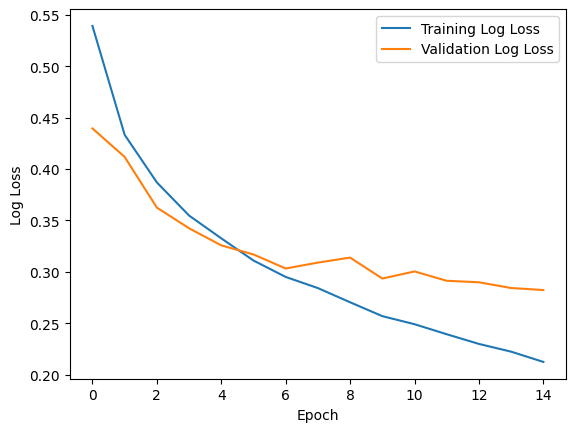

In [ ]:
plt.plot(history.history['log_loss'], label='Training Log Loss')
plt.plot(history.history['val_log_loss'], label='Validation Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# Test

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Directory where test images are stored
test_image_dir = '/content/drive/MyDrive/zindi/data/test'

# Get all filenames from the test directory
test_filenames = os.listdir(test_image_dir)

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame()

# Process each image and make predictions
for filename in test_filenames:
    # Load image
    img_path = os.path.join(test_image_dir, filename)
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)

    # Preprocess the image
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    # Make predictions
    predictions = model.predict(img_preprocessed)
    # Add the filename and predictions to the DataFrame
    results_df = results_df.append({'filename': filename, **dict(zip(label_columns, predictions[0]))}, ignore_index=True)



#Submission

In [ ]:
dataf=pd.merge(test_df,results_df,on='filename')
results_df=dataf.drop('filename',axis=1)
# Save the DataFrame to a CSV file
results_df.to_csv('SampleSubmission.csv', index=False)
